# Relevance Vector Machine (Stochastic Variational Sparse Gaussian Process)

---

## セットアップ

### モジュールの読み込み

In [1]:
import numpy as np
import torch
import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [2]:
import sys
sys.path.append("../")

from models import VSGP
from kernels import RBF
from kernels import RVM
from likelihoods import Binary

In [3]:
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize

### 設定

In [4]:
# 乱数シードを固定
pyro.set_rng_seed(4)

In [5]:
# テンソルのdtypeをデフォルトで倍精度に設定
torch.set_default_dtype(torch.float64)

---

## データの生成

In [6]:
centroids = torch.rand(10, 2) * 10 - 5
X = torch.tile(centroids, (10, 1)) + torch.rand(100, 2) * 3 - 1.5
y = torch.tensor([1 if i % 2 == 0 else 0 for i in range(X.shape[0])], dtype = torch.get_default_dtype()).unsqueeze(1)

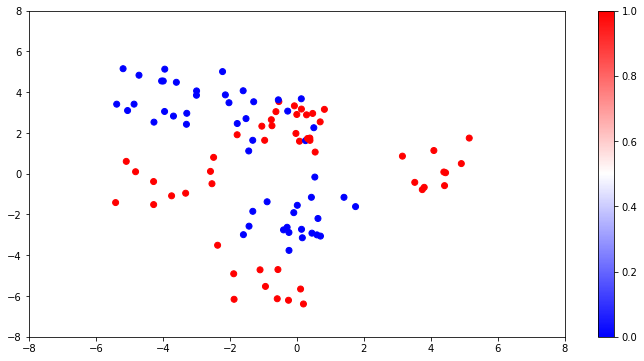

In [7]:
plt.figure(figsize = (12, 6))
plt.scatter(x = X[:, 0], y = X[:, 1], c = y[:, 0], cmap = "bwr")
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.colorbar()
plt.show()

---

## 推論

In [8]:
pyro.clear_param_store()

dataset = torch.utils.data.TensorDataset(X, y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 10, shuffle = True)

kernel = RVM(RBF(), X)
likelihood = Binary()
Z = X[:20, :].clone()
estimator = VSGP(Z, 1, kernel, likelihood, whiten = True)

svi = SVI(
    estimator.model,
    estimator.guide,
    Adam({"lr": 0.01}),
    loss = Trace_ELBO(retain_graph = True)
)

n_epochs = 1000
for epoch in range(n_epochs):
    for batch_X, batch_y in dataloader:
        loss = svi.step(batch_X, batch_y, num_data = X.shape[0])
    if epoch % (n_epochs / 10) == 0:
        print(loss)

204.8753727191035
12.699011214632232
16.72795406462489
21.251514730292392
15.533117341838686
29.905108244046698
9.57945903094002
38.42454363693852
17.30327937836394
30.51194761742414


---

## 推論結果

### 予測分布

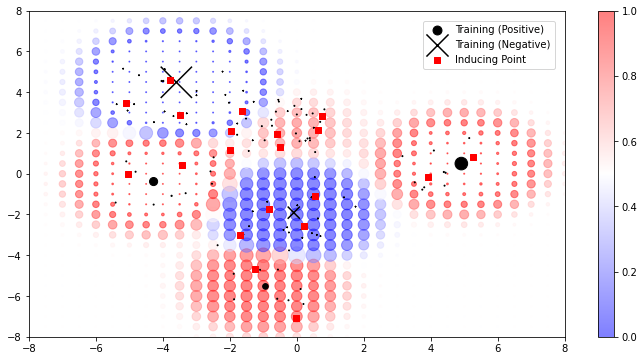

CPU times: user 13.8 s, sys: 1.12 s, total: 14.9 s
Wall time: 3.99 s


In [9]:
%%time
with torch.no_grad():
    Xnew = torch.tensor([[x, y] for x in np.linspace(-8, 8, 33) for y in np.linspace(-8, 8, 33)], dtype = torch.get_default_dtype())
    fnew, ynew = estimator(Xnew, 100)
    pnew = torch.sigmoid(fnew)
    pnew_mean = pnew.mean(axis = 0)
    pnew_std = pnew.std(axis = 0)

    sr = estimator.kernel.relevance
    sr = (sr - sr.min()) / sr.std() * 100 + 1
    sp = pnew_std[:, 0]
    sp = ((sp - sp.min()) / sp.std()) * 50 + 1

    plt.figure(figsize = (12, 6))
    plt.scatter(
        x = Xnew[:, 0], y = Xnew[:, 1],
        s = sp,
        c = pnew_mean[:, 0], cmap = "bwr", norm = Normalize(vmin = 0, vmax = 1), alpha = 0.5,
        marker = "o"
    )
    plt.colorbar()
    plt.scatter(
        x = X[y[:, 0] == 1, 0], y = X[y[:, 0] == 1, 1],
        s = sr[y[:, 0] == 1],
        c = "black",
        marker = "o",
        label = "Training (Positive)"
    )
    plt.scatter(
        x = X[y[:, 0] == 0, 0], y = X[y[:, 0] == 0, 1],
        s = sr[y[:, 0] == 0],
        c = "black",
        marker = "x",
        label = "Training (Negative)"
    )
    plt.scatter(x = estimator.Z[:, 0], y = estimator.Z[:, 1], c = "red", marker = "s", label = "Inducing Point")
    plt.xlim(-8, 8)
    plt.ylim(-8, 8)
    plt.legend(bbox_to_anchor = (1, 1), loc = "upper right", borderaxespad = 1)
    plt.show()

### ハイパーパラメーター

In [10]:
estimator.kernel.relevance

tensor([9.0789e-03, 7.7870e-01, 1.9055e+03, 2.0324e-02, 1.0798e-01, 1.2862e-01,
        1.2395e-01, 1.8419e-01, 9.4367e-03, 1.5056e-01, 6.2503e-03, 9.0950e+00,
        8.2221e-02, 3.0224e-03, 1.2796e-01, 3.2983e-03, 1.5495e-01, 1.3403e-01,
        9.3533e-03, 5.6464e-02, 2.9659e-03, 2.2705e-01, 2.7328e+00, 4.8631e-01,
        4.7957e-01, 1.5475e-01, 6.7006e-01, 3.5861e-02, 5.0560e-01, 2.5959e-02,
        9.4878e-04, 4.1411e-02, 1.7503e-01, 9.4322e-03, 1.0158e-01, 9.4876e-03,
        2.3153e+00, 1.5842e-01, 1.7384e-02, 3.7671e-02, 4.6684e-03, 3.4218e-01,
        6.5595e-02, 5.5557e-03, 2.7520e-01, 5.7535e-01, 1.1493e-02, 1.8894e-02,
        3.1609e-03, 6.2508e-02, 1.7557e-01, 1.1816e+04, 7.3217e-02, 4.7601e-03,
        7.7984e+02, 2.3839e-02, 4.0740e-02, 5.6466e-02, 1.7614e-02, 2.1870e+00,
        7.1337e-02, 2.8599e-01, 1.7645e+00, 9.4797e-04, 4.9775e-01, 9.5178e-02,
        1.8621e-02, 7.7301e-02, 7.9319e-03, 2.9017e-02, 2.9791e-03, 3.3114e-01,
        2.1355e-01, 1.5264e-03, 1.6691e-

In [11]:
estimator.kernel.kernel.scale

tensor(0.9643, grad_fn=<AddBackward0>)

### 変分パラメーター

In [12]:
estimator.Z

Parameter containing:
tensor([[-0.5825,  1.9625],
        [-5.1130,  3.4792],
        [ 5.2773,  0.8204],
        [-2.0018,  1.1523],
        [-3.4406,  0.4088],
        [-3.4993,  2.8817],
        [-1.2444, -4.6823],
        [ 0.2294, -2.5558],
        [ 0.7582,  2.8525],
        [-1.7111, -3.0009],
        [ 0.6290,  2.1472],
        [-3.7946,  4.5982],
        [ 3.9255, -0.1515],
        [-1.6220,  3.0633],
        [-5.0429, -0.0325],
        [-1.9557,  2.0972],
        [-0.0246, -7.0666],
        [ 0.5465, -1.0828],
        [-0.5127,  1.3298],
        [-0.8300, -1.7146]], requires_grad=True)

In [13]:
estimator.u_loc

Parameter containing:
tensor([[ 0.9594, -1.3420,  1.0101,  0.9883,  1.0777, -0.0272,  1.0419, -1.0916,
          0.2678,  0.0428,  0.0284, -0.0847,  0.0815, -0.0837, -0.0628, -0.0837,
          0.0238,  0.0498,  0.0137, -0.1495]], requires_grad=True)

In [14]:
estimator.u_cov

tensor([[[ 2.3136e-01, -7.2431e-03, -8.2689e-03,  6.6259e-02, -1.1269e-02,
          -1.7868e-02, -5.1658e-02,  1.6216e-02, -9.2197e-02, -1.8760e-02,
           4.9740e-02,  9.5774e-04,  3.6918e-02,  2.8510e-02,  4.1495e-02,
           3.2307e-03, -7.6553e-02, -6.3788e-03,  2.1803e-02, -2.7089e-02],
         [-7.2431e-03,  8.1211e-02,  3.9561e-03,  1.2981e-02, -1.8284e-02,
          -2.0208e-02,  9.4706e-03,  1.1935e-02,  3.9133e-02,  4.0156e-03,
           4.9414e-02, -7.8124e-02,  4.4652e-04, -1.9754e-03,  4.2281e-03,
          -2.1831e-02,  3.1282e-02, -6.7658e-03, -1.3267e-02,  3.3733e-02],
         [-8.2689e-03,  3.9561e-03,  1.2503e-01, -3.7184e-02,  1.8291e-02,
          -2.4053e-02,  4.8032e-02,  4.5683e-02,  2.1205e-02, -2.8923e-02,
          -1.5090e-02,  3.6014e-02,  2.0495e-03,  1.4084e-02,  1.0791e-02,
           6.3780e-03,  3.6750e-02,  2.7228e-02,  1.6726e-02, -9.1182e-03],
         [ 6.6259e-02,  1.2981e-02, -3.7184e-02,  2.3621e-01, -2.0726e-01,
           9.5817e-03,